In [1]:
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
def exp_map(H):
    epsilon = 1e-6
    # H.shape: batch x n-1 x k
    n_minus_1 = int(H.shape[-2])
    zero_row = tf.zeros((1,n_minus_1))        # 1 x n-1
    I = tf.eye(n_minus_1)                     # n-1 x n-1
    zero_I = tf.concat((zero_row, I), axis=0) # n x n-1

    v_mat = tf.matmul(zero_I, H)                  # batch x n x k
    v_norm_vec = tf.linalg.norm(v_mat,axis=1)     # batch x k
    v_norm_row_vec = tf.expand_dims(v_norm_vec,1) # batch x 1 x k
    v_norm_diag = tf.linalg.diag(v_norm_vec)      # batch x k x k
    inv_v_norm_diag = tf.linalg.diag(1/(v_norm_vec+epsilon))
    sin_over_norm = tf.linalg.matmul(tf.math.sin(v_norm_diag),inv_v_norm_diag) # batch x k x k

    e1 = tf.eye(n_minus_1+1,1) # n x 1
    
    cos_term = tf.linalg.matmul(e1, tf.math.cos(v_norm_row_vec))
    sin_term = tf.linalg.matmul(v_mat, sin_over_norm)
    
    exp_mapped_vs = cos_term+sin_term
    
    return exp_mapped_vs

In [3]:
H = tf.random.uniform([1,6,1],minval=-10,maxval=10)
print(H.shape)

2022-09-21 12:41:43.600528: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-21 12:41:43.680124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 12:41:43.680415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3070 major: 8 minor: 6 memoryClockRate(GHz): 1.755
pciBusID: 0000:01:00.0
2022-09-21 12:41:43.680606: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib::/home/kerrick/.mujoco/mujoco210/bin:/usr/lib/nvidia
2022-09-21 12:41:43.680692: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not

(1, 6, 1)


In [4]:
v = exp_map(H)
print(v)
print(v.shape)
print(tf.linalg.norm(v,axis=1))

tf.Tensor(
[[[ 0.464843  ]
  [ 0.34697503]
  [-0.17921494]
  [-0.66284716]
  [ 0.11157613]
  [ 0.03711525]
  [-0.42215884]]], shape=(1, 7, 1), dtype=float32)
(1, 7, 1)
tf.Tensor([[0.9999999]], shape=(1, 1), dtype=float32)


In [13]:
def sample_uniform_vec(minval,maxval,shape):
    return tf.random.uniform(shape,minval=minval,maxval=maxval)

In [6]:
H = sample_uniform_vec(-10,10,[1,6,2])
print(H.shape)
V = exp_map(H)
print(V.shape)
print(tf.linalg.norm(V[0,:,0]))
print(tf.linalg.norm(V[0,:,1]))

(1, 6, 2)
(1, 7, 2)
tf.Tensor(0.99999994, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [7]:
H = sample_uniform_vec(-10,10,[2,6,3])
print(H.shape)
V = exp_map(H)
print(V.shape)

print(tf.linalg.norm(V[0,:,0]))
print(tf.linalg.norm(V[0,:,1]))
print(tf.linalg.norm(V[0,:,2]))

print(tf.linalg.norm(V[1,:,0]))
print(tf.linalg.norm(V[1,:,1]))
print(tf.linalg.norm(V[1,:,2]))

(2, 6, 3)
(2, 7, 3)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.99999994, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.99999994, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [11]:
def sample_vec_batch(batch, MLP_out_dim, scale):
    return sample_uniform_vec(-scale,scale,[batch, MLP_out_dim])

def reshape_MLP_output(MLP_out, rows, cols):
    return tf.reshape(MLP_out, [-1, rows, cols])

In [33]:
BATCH_SIZE = 2
n = 7
k = 2

In [35]:
vec = sample_vec_batch(BATCH_SIZE, (n-1)*k, scale=1)
print(vec)
print(vec.shape)

#tf.reshape(x, [-1, self.output_dim-1, self.action_dim])
V = exp_map(reshape_MLP_output(vec, n-1, k))
print(V)
print(V.shape)
print(tf.linalg.norm(V,axis=1,ord=2))

flattened_V = tf.reshape(tf.transpose(V,(0,2,1)), [BATCH_SIZE, -1, 1])
print(V)
print(flattened_V)

V_reformed = tf.transpose(tf.reshape(flattened_V, [BATCH_SIZE, k, n]),(0,2,1))
print(V_reformed)


tf.Tensor(
[[-0.67232275  0.8884256  -0.7355492   0.12571979  0.23190618  0.34444594
  -0.5589528   0.7216704  -0.38281822  0.7014146  -0.41756272 -0.68667436]
 [-0.8048918  -0.14457083 -0.49596334  0.65454197  0.33098912  0.3377514
  -0.20919704  0.80222344 -0.2927971   0.16494012 -0.14400148 -0.07140136]], shape=(2, 12), dtype=float32)
(2, 12)
tf.Tensor(
[[[ 0.2711461   0.01900244]
  [-0.49925122  0.5724119 ]
  [-0.5462017   0.08100116]
  [ 0.17220813  0.22192624]
  [-0.41506535  0.46497166]
  [-0.2842719   0.45192087]
  [-0.31007236 -0.44242373]]

 [[ 0.476555    0.44177145]
  [-0.65882057 -0.11650698]
  [-0.40595624  0.5274834 ]
  [ 0.27092144  0.27218765]
  [-0.1712321   0.6464972 ]
  [-0.23966047  0.13292222]
  [-0.11786819 -0.05754105]]], shape=(2, 7, 2), dtype=float32)
(2, 7, 2)
tf.Tensor(
[[0.9999992 0.9999994]
 [0.9999992 0.9999993]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[[ 0.2711461   0.01900244]
  [-0.49925122  0.5724119 ]
  [-0.5462017   0.08100116]
  [ 0.17220813  0.2

In [27]:
def exp_map_function(vec, n, k):
    V = exp_map(reshape_MLP_output(vec, n-1, k))
    if len(V.shape) < 3:
        V = V.unsqueeze(0)
        V = V.unsqueeze(-1)
    flattened_V = tf.reshape(tf.transpose(V,(0,2,1)), [BATCH_SIZE, -1])
    return flattened_V

In [20]:
def empirical_Lipschitz_test(n_samples, input_shape, input_scale, func):

    input_diff_norms = []
    output_diff_norms = []

    for _ in range(n_samples):
        # sample vecs
        vec1 = sample_vec_batch(input_shape[0], input_shape[1], input_scale)
        vec2 = sample_vec_batch(input_shape[0], input_shape[1], input_scale)

        # get norm of difference
        input_diff_norm = tf.linalg.norm(vec2-vec1, axis=-1, ord=2)

        # pass through func
        out1 = func(vec1)
        out2 = func(vec2)

        output_diff_norm = tf.linalg.norm(out2-out1, axis=-1, ord=2)

        # store data
        input_diff_norms.append(input_diff_norm)
        output_diff_norms.append(output_diff_norm)

    return input_diff_norms, output_diff_norms

In [28]:
BATCH_SIZE = 1
k = 1
n = 7


n_samples = 800


input_shape = [BATCH_SIZE, (n-1)*k]

vec = sample_vec_batch(input_shape[0], input_shape[1], 1)
out = exp_map_function(vec, n, k)

print(vec.shape)
print(out.shape)

(1, 6)
(1, 7)


tf.Tensor([1.9865379], shape=(1,), dtype=float32)
tf.Tensor([1.6471382], shape=(1,), dtype=float32)


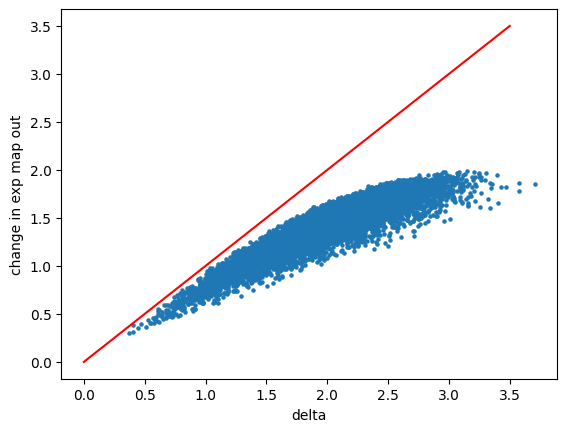

In [30]:
import matplotlib.pyplot as plt

BATCH_SIZE = 1
k = 1
n = 7


n_samples = 8000


input_shape = [BATCH_SIZE, (n-1)*k]


input_scale = 1

def specific_exp_map(vec):
    return exp_map_function(vec, n, k)

input_diff_norms, output_diff_norms = empirical_Lipschitz_test(n_samples, input_shape, input_scale, specific_exp_map)   

print(input_diff_norms[0])
print(output_diff_norms[0])

plt.scatter(input_diff_norms, output_diff_norms, s=5)
plt.xlabel('delta')
plt.ylabel('change in exp map out')

x = np.linspace(0,3.5,500)
y = x

plt.plot(x,y, color='r')

plt.show()

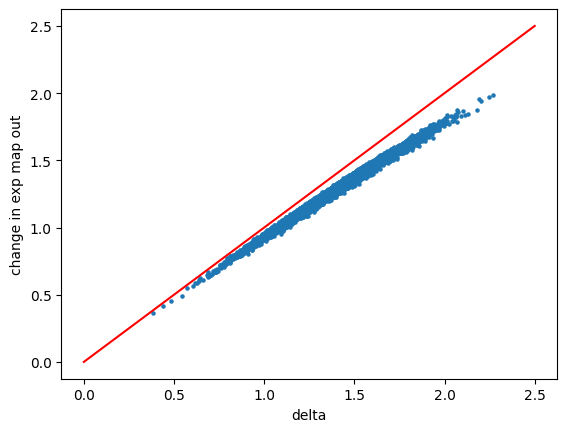

In [31]:
import matplotlib.pyplot as plt

BATCH_SIZE = 1
k = 2
n = 7

def specific_exp_map(vec):
    return exp_map_function(vec, n, k)

n_samples = 8000


input_shape = [BATCH_SIZE, (n-1)*k]

input_scale = 0.5

input_diff_norms, output_diff_norms = empirical_Lipschitz_test(n_samples, input_shape, input_scale, specific_exp_map)    

plt.scatter(input_diff_norms, output_diff_norms, s=5)
plt.xlabel('delta')
plt.ylabel('change in exp map out')

x = np.linspace(0,2.5,500)
y = x

plt.plot(x,y, color='r')

plt.show()

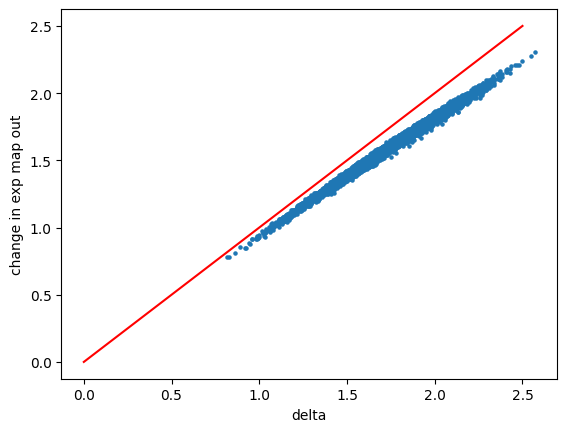

In [32]:
BATCH_SIZE = 1
k = 3
n = 7

def specific_exp_map(vec):
    return exp_map_function(vec, n, k)

n_samples = 8000
input_shape = [BATCH_SIZE, (n-1)*k]

input_scale = 0.5

input_diff_norms, output_diff_norms = empirical_Lipschitz_test(n_samples, input_shape, input_scale, specific_exp_map)    

plt.scatter(input_diff_norms, output_diff_norms, s=5)
plt.xlabel('delta')
plt.ylabel('change in exp map out')

x = np.linspace(0,2.5,500)
y = x

plt.plot(x,y, color='r')

plt.show()

In [42]:
def householder(H):
    # Note, we assume the columns of H already have unit length, 
    # thanks to the exponential map to the unit sphere
    k = H.shape[-1] # number of vectors from which to construct reflections
    Q = tf.eye(int(H.shape[-2]))
    I = tf.eye(int(H.shape[-2]))
    
    for c in range(k):
        v = tf.expand_dims(H[:,:,c],-1) # batch x n x 1
        vT = tf.transpose(v,(0,2,1))    # batch x 1 x n
        vvT = tf.matmul(v,vT)           # batch x n x n
        H_i =  I - 2*vvT                # batch x n x n
        Q = tf.matmul(Q, H_i)   # batch x n x n

    return Q[:,:,:k] # H_hat


from math import isclose

def exp_householder_Lipschitz_test(n_samples, batch_size, n, k, input_scale):

    input_diff_norms = []
    output_diff_norms = []

    for _ in range(n_samples):
        # sample vecs
        vec1 = sample_vec_batch(batch_size, (n-1)*k, input_scale)
        vec2 = sample_vec_batch(batch_size, (n-1)*k, input_scale)

        v1 = exp_map_function(vec1, n, k)
        v2 = exp_map_function(vec2, n, k)

        assert isclose(tf.linalg.norm(v1[0,:n]),1, abs_tol=1e-6)
        assert isclose(tf.linalg.norm(v2[0,:n]),1, abs_tol=1e-6)

        # get norm of difference
        input_diff_norm = tf.linalg.norm(v2-v1, axis=-1, ord=2)

        # reshape to mat for householder
        V1 = tf.transpose(tf.reshape(v1, [batch_size, k, n]),(0,2,1))
        V2 = tf.transpose(tf.reshape(v2, [batch_size, k, n]),(0,2,1))

        # pass through func
        out1 = householder(V1)
        out2 = householder(V2)

        output_diff_norm = tf.linalg.norm(out2-out1, ord=2,axis=(1,2))

        # store data
        input_diff_norms.append(input_diff_norm)
        output_diff_norms.append(output_diff_norm)

    return input_diff_norms, output_diff_norms

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


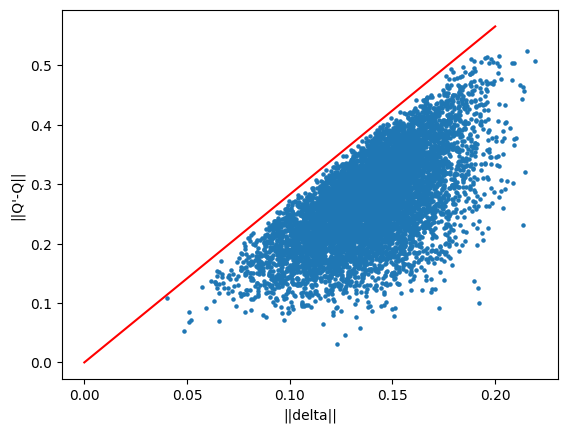

In [43]:
BATCH_SIZE = 1
k = 2
n = 7

n_samples = 8000

input_scale = 0.05
input_diff_norms, output_diff_norms = exp_householder_Lipschitz_test(n_samples, BATCH_SIZE, n, k, input_scale)

plt.scatter(input_diff_norms, output_diff_norms, s=5)
plt.xlabel('||delta||')
plt.ylabel('||Q\'-Q||')

x = np.linspace(0,0.2,500)
y = 2*np.sqrt(k)*x

plt.plot(x,y, color='r')

plt.show()

In [52]:
def composed_exp_householder_Lipschitz_test(n_samples, batch_size, n, k, input_scale):

    input_diff_norms = []
    output_diff_norms = []

    for _ in range(n_samples):
        # sample vecs
        vec1 = sample_vec_batch(batch_size, (n-1)*k, input_scale)
        vec2 = sample_vec_batch(batch_size, (n-1)*k, input_scale)
        
        # get norm of difference
        input_diff_norm = tf.linalg.norm(tf.identity(vec2)-tf.identity(vec1), axis=-1, ord=2)
        
        v1 = exp_map_function(vec1, n, k)
        v2 = exp_map_function(vec2, n, k)
        

        assert isclose(tf.linalg.norm(v1[0,:n]),1, abs_tol=1e-6), f'{tf.linalg.norm(v1[0,:n])}'
        assert isclose(tf.linalg.norm(v2[0,:n]),1, abs_tol=1e-6), f'{tf.linalg.norm(v2[0,:n])}'


        # reshape to mat for householder
        V1 = tf.transpose(tf.reshape(v1, [batch_size, k, n]),(0,2,1))
        V2 = tf.transpose(tf.reshape(v2, [batch_size, k, n]),(0,2,1))

        # pass through func
        out1 = householder(V1)
        out2 = householder(V2)

        output_diff_norm = tf.linalg.norm(tf.identity(out2)-tf.identity(out1), ord=2,axis=(1,2))

        # store data
        input_diff_norms.append(input_diff_norm)
        output_diff_norms.append(output_diff_norm)

    return input_diff_norms, output_diff_norms

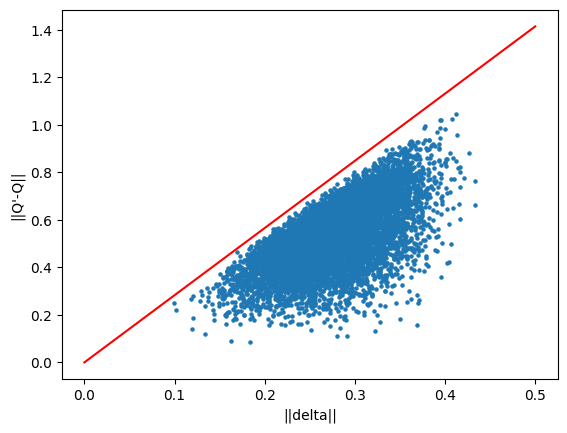

In [53]:
BATCH_SIZE = 1
k = 2
n = 7


n_samples = 8000

input_scale = 0.1
input_diff_norms, output_diff_norms = composed_exp_householder_Lipschitz_test(n_samples, BATCH_SIZE, n, k, input_scale)

plt.scatter(input_diff_norms, output_diff_norms, s=5)
plt.xlabel('||delta||')
plt.ylabel('||Q\'-Q||')

x = np.linspace(0,0.5,500)
y = 2*np.sqrt(k)*x

plt.plot(x,y, color='r')

plt.show()

In [55]:
def no_reshape_exp_map_function(vec, n, k):
    V = exp_map(reshape_MLP_output(vec, n-1, k))
    if len(V.shape) < 3:
        V = V.unsqueeze(0)
        V = V.unsqueeze(-1)
        
    return V

In [56]:
def no_reshape_composed_exp_householder_Lipschitz_test(n_samples, batch_size, n, k, input_scale):

    input_diff_norms = []
    output_diff_norms = []

    for _ in range(n_samples):
        # sample vecs
        vec1 = sample_vec_batch(batch_size, (n-1)*k, input_scale)
        vec2 = sample_vec_batch(batch_size, (n-1)*k, input_scale)
        
        # get norm of difference
        input_diff_norm = tf.linalg.norm(tf.identity(vec2)-tf.identity(vec1), axis=-1, ord=2)
        
        V1 = no_reshape_exp_map_function(vec1, n, k)
        V2 = no_reshape_exp_map_function(vec2, n, k)
        

        assert isclose(tf.linalg.norm(V1[0,:,1]),1, abs_tol=1e-6), f'{tf.linalg.norm(V1[0,:,1])}'
        assert isclose(tf.linalg.norm(V2[0,:,1]),1, abs_tol=1e-6), f'{tf.linalg.norm(V2[0,:,1])}'


        # pass through func
        out1 = householder(V1)
        out2 = householder(V2)

        output_diff_norm = tf.linalg.norm(tf.identity(out2)-tf.identity(out1), ord=2,axis=(1,2))

        # store data
        input_diff_norms.append(input_diff_norm)
        output_diff_norms.append(output_diff_norm)

    return input_diff_norms, output_diff_norms

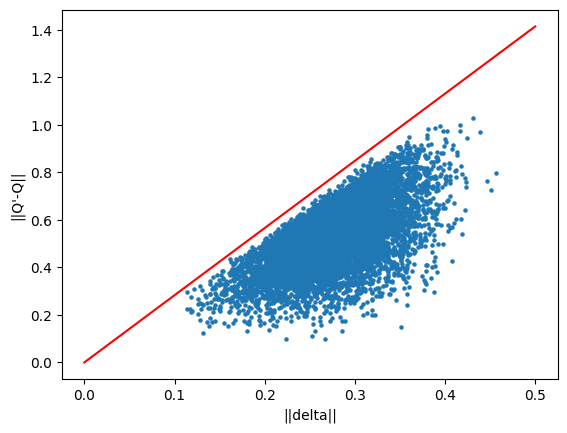

In [57]:
BATCH_SIZE = 1
k = 2
n = 7


n_samples = 8000

input_scale = 0.1
input_diff_norms, output_diff_norms = no_reshape_composed_exp_householder_Lipschitz_test(n_samples, BATCH_SIZE, n, k, input_scale)

plt.scatter(input_diff_norms, output_diff_norms, s=5)
plt.xlabel('||delta||')
plt.ylabel('||Q\'-Q||')

x = np.linspace(0,0.5,500)
y = 2*np.sqrt(k)*x

plt.plot(x,y, color='r')

plt.show()

In [62]:
# sanity check
max_delta = np.sqrt((n-1)*k*((2*input_scale)**2))
print(max_delta)

big_d = tf.convert_to_tensor(np.array([2*input_scale]*k*(n-1)))
print(tf.linalg.norm(big_d))

0.692820323027551
tf.Tensor(0.692820323027551, shape=(), dtype=float64)
